# Movie Data Project: Final Jupyter Notebook

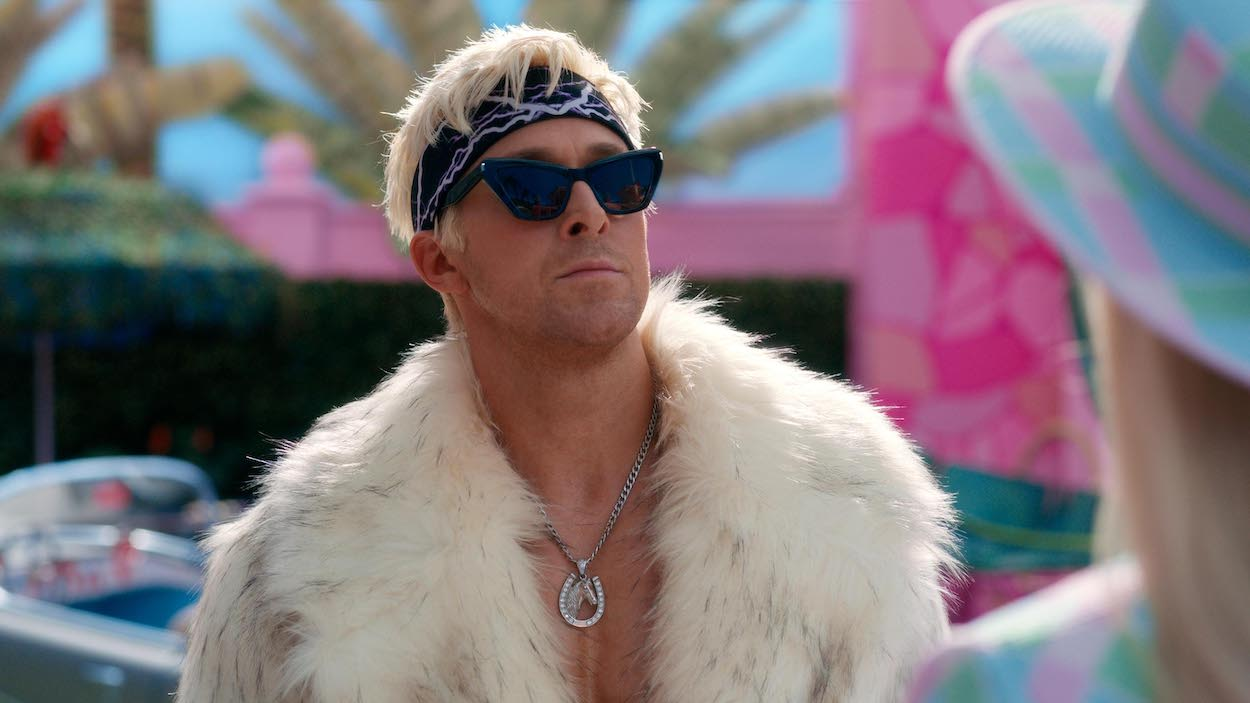

Welcome!!! To my mojo dojo casa house!

## Business Problem

This is the problem our project is specifying:

`"Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create."`

In this notebook, we do the following:

- Clean data from The Numbers to get profitability data for a given set of films

- Query the data from IMDB to get features we'd like to analyze profit on

- Pull in supplemental IMBD data to fill in large gaps between these two datasets

- Combine everything together into one cleaned set

- Analyze the cleaned data to determine the effect of various features on profitability

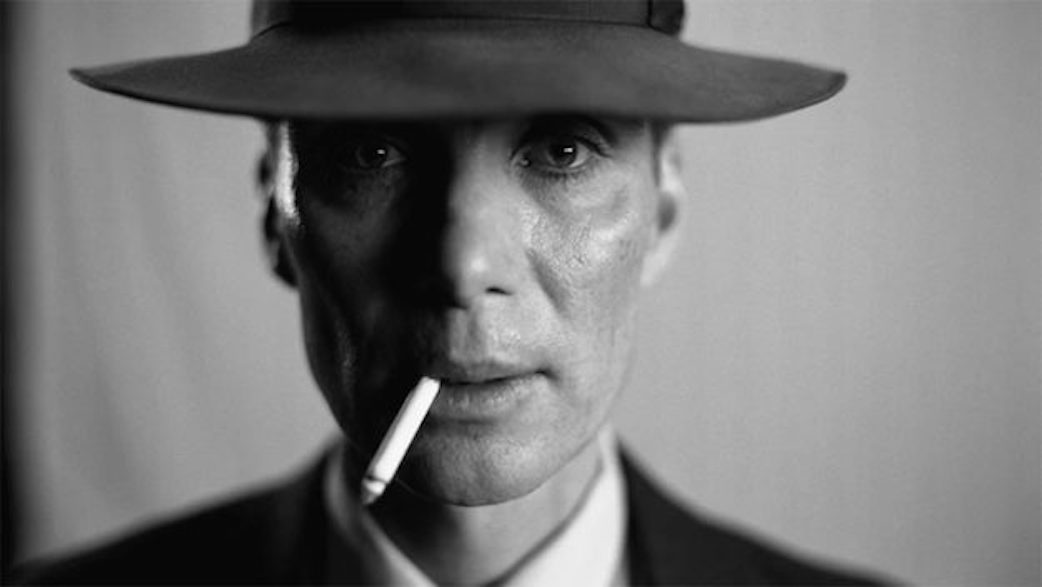

Now me am become data

## Data Cleaning

We determined in our EDA that the dataset from The Numbers will be our target list of movies to analyze, as we really like the profitability measures it provides.

We also like the features that the IMDB set provides for movies, and would like to get the IMDB data for all the movies in our target set to use in our analysis.

In this section we prepare our master data set by doing the following:
   - Load in and clean The Numbers dataset
   - Query our IMDB dataset and clean it up
   - Load in supplemental IMDB data that we pulled from Kaggle
   - Combine all data and export cleaned master data set

### Imports

In [1]:
import pandas as pd
import sqlite3
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.0f}'.format

In [2]:
# To silence the very annoying 'Copy on a Slice' warnings
import warnings
warnings.simplefilter('ignore')

### The Numbers Dataset

Let's load in our target list and clean it up a bit!

In [3]:
tn_budgets = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz', parse_dates=['release_date'], encoding='utf-8')

tn_budgets.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


Because movie tastes have changed drastically over time, we decided to exclude movies released before the year 2000.

In [4]:
# Create release year
tn_budgets['release_year'] = tn_budgets['release_date'].dt.year

# Filter out movies before 2000
tn_clean = tn_budgets[tn_budgets['release_year'] >= 2000]

tn_clean.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
0,1,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011


We want to add features for Gross Profit and Gross ROI, but in order to calculate them we will need to convert the budget and revenue measures to floats. 

In [5]:
# Using lambda to convert the strings to floats after stripping the dollar signs and commas

tn_clean['production_budget'] = tn_clean['production_budget'].apply(
    lambda x: float(x.replace('$', '').replace(',', '')))

tn_clean['domestic_gross'] = tn_clean['domestic_gross'].apply(
    lambda x: float(x.replace('$', '').replace(',', '')))

tn_clean['worldwide_gross'] = tn_clean['worldwide_gross'].apply(
    lambda x: float(x.replace('$', '').replace(',', '')))

# Calculating gross profit
tn_clean['Global_Gross_Profit'] = tn_clean['worldwide_gross'] - tn_clean['production_budget']

# Calculating gross ROI
tn_clean['Global_Gross_ROI'] = (tn_clean['Global_Gross_Profit'] / tn_clean['production_budget'])

tn_clean.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,Global_Gross_Profit,Global_Gross_ROI
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,2009,2351345279,6
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,635063875,2


Now let's drop some columns and clean up the remaining ones.

In [6]:
# Drop the unnecessary columns
tn_clean = tn_clean.drop(columns=['id', 'release_date'])

# Let's use a dictionary to rename our columns to match our other dataset
rename_dict = {'movie':'Title', 'production_budget':'Budget', 'domestic_gross':'Domestic_Gross_Rev', 
               'worldwide_gross':'Global_Gross_Rev', 'release_year':'Year'}

tn_clean = tn_clean.rename(columns=rename_dict)

tn_clean.head(10)

,Title,Budget,Domestic_Gross_Rev,Global_Gross_Rev,Year,Global_Gross_Profit,Global_Gross_ROI
0,Avatar,425000000,760507625,2776345279,2009,2351345279,6
1,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,635063875,2
2,Dark Phoenix,350000000,42762350,149762350,2019,-200237650,-1
3,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,1072413963,3
4,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,999721747,3
5,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2015,1747311220,6
6,Avengers: Infinity War,300000000,678815482,2048134200,2018,1748134200,6
7,Pirates of the Caribbean: At Worldâs End,300000000,309420425,963420425,2007,663420425,2
8,Justice League,300000000,229024295,655945209,2017,355945209,1
9,Spectre,300000000,200074175,879620923,2015,579620923,2


Huh? Looks like an encoding error in the Title column, 7th index...

In [7]:
tn_clean['Title'].values.tolist()

['Avatar',
 'Pirates of the Caribbean: On Stranger Tides',
 'Dark Phoenix',
 'Avengers: Age of Ultron',
 'Star Wars Ep. VIII: The Last Jedi',
 'Star Wars Ep. VII: The Force Awakens',
 'Avengers: Infinity War',
 'Pirates of the Caribbean: At Worldâ\x80\x99s End',
 'Justice League',
 'Spectre',
 'The Dark Knight Rises',
 'Solo: A Star Wars Story',
 'The Lone Ranger',
 'John Carter',
 'Tangled',
 'Spider-Man 3',
 'Captain America: Civil War',
 'Batman v Superman: Dawn of Justice',
 'The Hobbit: An Unexpected Journey',
 'Harry Potter and the Half-Blood Prince',
 'The Hobbit: The Desolation of Smaug',
 'The Hobbit: The Battle of the Five Armies',
 'The Fate of the Furious',
 'Superman Returns',
 'Pirates of the Caribbean: Dead Men Tell No Tales',
 'Quantum of Solace',
 'The Avengers',
 'Pirates of the Caribbean: Dead Manâ\x80\x99s Chest',
 'Man of Steel',
 'The Chronicles of Narnia: Prince Caspian',
 'The Amazing Spider-Man',
 'Battleship',
 'Transformers: The Last Knight',
 'Jurassic World

We definitely found an encoding issue here. After trying various ways to normalize it or find the ideal encoding parameter to read the data in with, we were not able to fix it. 

Luckily, we identified 3 distinct patterns, each corresponding to its own misread character. We wrote a manual normalize function here to solve this problem. Put some lipstick on that pig!

In [8]:
# Write manual normalizer to fix these encoding issues
def normalize_text(text):
    return text.replace('â\x80\x99', "'").replace('â\x80\x94', " ").replace('Ã©', "e")

# Apply the function to clean up the Title column
tn_clean['Title'] = tn_clean['Title'].apply(lambda x: normalize_text(x))

tn_clean.head(10)

,Title,Budget,Domestic_Gross_Rev,Global_Gross_Rev,Year,Global_Gross_Profit,Global_Gross_ROI
0,Avatar,425000000,760507625,2776345279,2009,2351345279,6
1,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,635063875,2
2,Dark Phoenix,350000000,42762350,149762350,2019,-200237650,-1
3,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,1072413963,3
4,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,999721747,3
5,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2015,1747311220,6
6,Avengers: Infinity War,300000000,678815482,2048134200,2018,1748134200,6
7,Pirates of the Caribbean: At World's End,300000000,309420425,963420425,2007,663420425,2
8,Justice League,300000000,229024295,655945209,2017,355945209,1
9,Spectre,300000000,200074175,879620923,2015,579620923,2


Looking good! Lastly we will get a list of target movies to use to filter our IMDB data. Then we get querying...

In [9]:
tn_clean['Title & Year'] = tn_clean.apply(lambda row: f"{row['Title']} - {row['Year']}", axis=1)

In [10]:
# Get normalized list
target_list = [normalize_text(i) for i in tn_clean['Title'].values.tolist()]
len(target_list)

4387

In [11]:
target_list_with_years = [normalize_text(i) for i in tn_clean['Title & Year'].values.tolist()]

### IMDB Dataset

In [12]:
import os
import zipfile

# Check if 'im.db' exists, unzip if it doesn't
if not os.path.exists('./zippedData/im.db'):
    with zipfile.ZipFile('./zippedData/im.db.zip', 'r') as zip_ref:
        zip_ref.extractall('./zippedData')

# Connect to the SQLite database
conn = sqlite3.connect('./zippedData/im.db')

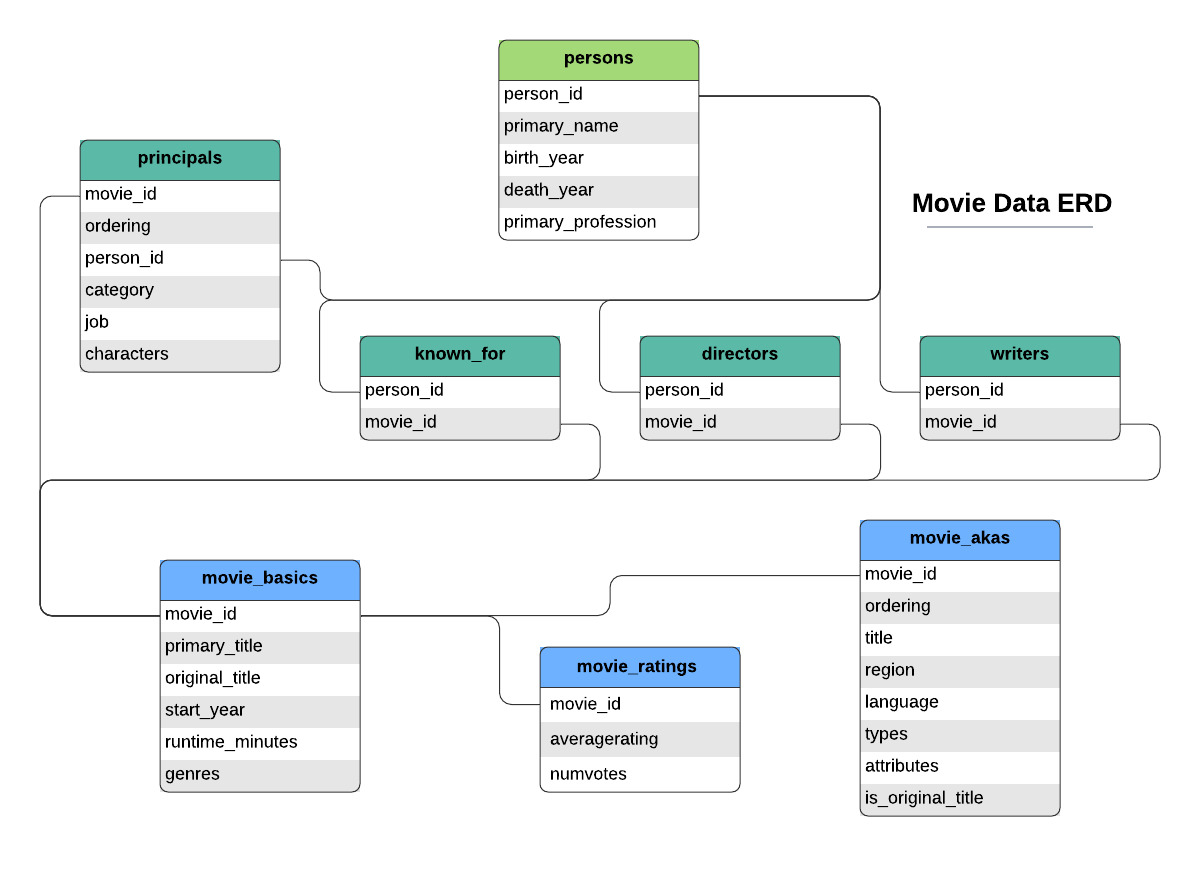

We wrote this massive query

The large table CTE is a combination on inner join of all the tables in the data set. Then for Actors, Directors, Writers, and Producers we wrote individual CTE's to move their names into one element per movie. This significantly cut down on processing time. Then we selected what we needed from these CTE's. 

In [13]:
# Here's our big query
movies_sql = pd.read_sql("""

WITH big_table AS (
    SELECT 
        mb.movie_id,
        mb.primary_title,
        mb.start_year,
        mb.runtime_minutes,
        mb.genres,
        mr.averagerating,
        mr.numvotes
    FROM movie_basics AS mb
        JOIN movie_ratings AS mr
            USING(movie_id)
        JOIN principals AS pr
            USING(movie_id)
        JOIN persons AS ps
            USING(person_id)
    WHERE mb.start_year > 2000
    GROUP BY mb.movie_id
    
),

ActorNames AS (
    SELECT 
        DISTINCT p.movie_id, 
        GROUP_CONCAT(pe.primary_name) AS Actors
    FROM principals p
        JOIN persons pe
            USING(person_id)
    WHERE p.category IN ('actor', 'actress', 'self')
    GROUP BY p.movie_id
),

WriterNames AS (
    SELECT 
        DISTINCT p.movie_id, 
        GROUP_CONCAT(pe.primary_name) AS Writers
    FROM principals p
        JOIN persons pe
            USING(person_id)
    WHERE p.category IN ('writer')
    GROUP BY p.movie_id
),

DirectorNames AS (
    SELECT 
        DISTINCT p.movie_id,
        GROUP_CONCAT(pe.primary_name) AS Directors
    FROM principals p
        JOIN persons pe
            USING(person_id)
    WHERE p.category IN ('director')
    GROUP BY p.movie_id
),

ProducerNames AS (
    SELECT 
        DISTINCT p.movie_id,
        GROUP_CONCAT(pe.primary_name) AS Producers
    FROM principals p
        JOIN persons pe
            USING(person_id)
    WHERE p.category IN ('producer')
    GROUP BY p.movie_id
)

    SELECT 
        b.movie_id AS ID,
        b.primary_title AS Title,
        b.start_year AS Year,
        b.runtime_minutes AS Runtime,
        b.genres AS Genres,
        b.averagerating AS AvgRating,
        b.numvotes AS VoteCount,
        a.Actors,
        w.Writers,
        d.Directors,
        p.Producers
    FROM big_table b
        JOIN ActorNames a
            USING(movie_id)
        JOIN WriterNames w
            USING(movie_id)
        JOIN DirectorNames d
            USING(movie_id)
        JOIN ProducerNames p
            USING(movie_id)
    ORDER BY b.primary_title
  ;
  """, conn)

In [14]:
movies_sql.head()

,ID,Title,Year,Runtime,Genres,AvgRating,VoteCount,Actors,Writers,Directors,Producers
0,tt2346170,#1 Serial Killer,2013,87,Horror,6,40,"Jason Tobin,Eugenia Yuan,Tzi Ma,Shoshana Bush",Koji Steven Sakai,Stanley Yung,Quentin Lee
1,tt5255986,#66,2015,116,Action,5,18,"Ari Riski Ananda,Erwin Bagindo,Fandy Christian...",Matthew Ryan Fischer,Asun Mawardi,Gina Maria
2,tt5803530,#DigitalLivesMatter,2016,nan,Comedy,6,19,"Rashan Ali,Carlos Aviles,Brooklyn Beedles,Ben ...",Cas Sigers-Beedles,Terri J. Vaughn,"Bobby Patterson,David Banner,D.C. Young Fly,An..."
3,tt5460468,#Enough,2015,nan,Drama,2,7,"Mark Boyd,Jebediah Calhoun,Sean Davis,Adriane ...",Damion Stevenson,Miranda Ferguson,"John Boudreau,Joseph Calhoun"
4,tt5233106,#FollowFriday,2016,90,Thriller,3,186,"Courtney Lakin,Joseph Poliquin,Ashley Bratcher...","Marie Bertonneau,Anna Rasmussen",Micho Rutare,David Michael Latt


In [15]:
movies_sql.shape

(21414, 11)

Phew, it worked. That's a lot of movies. Let's exclude all records here that are not for movies in our target list. 

In [16]:
# Slice our DataFrame to exclude movies not in our target list
movies_sql = movies_sql[movies_sql['Title'].isin(target_list) == True]
movies_sql.shape

(1446, 11)

After filtering with our target list, we only have 1446 records. We're glad it's more manageable, but we clearly don't have the features to analyze for all 4387 of our target movies.

... So we went looking for more. We found more IMDB data (a whole lot more) on kaggle, linked [here](https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset?select=title.akas.tsv).

We worked with this set in another notebook and import the cleaned data below to merge with our existing data.

### More IMDB Data

Now we load up our extra IMDB data, combine it with this data from SQL, then filter it to match our target list exactly.

In [17]:
# Load it up
imdb_extra = pd.read_csv('./cleanedData/imdb_supplemental_cleaned.csv')
imdb_extra.head(2)

,Unnamed: 0,ID,Title,Year,Runtime,Genres,AvgRating,VoteCount,Directors,Producers,Writers,Actors
0,0,tt0118589,Glitter,2001,104,"Drama,Music,Romance",2,23898,Vondie Curtis-Hall,Laurence Mark,"Cheryl L. West, Kate Lanier","Mariah Carey, Eric Benét, Max Beesley, Da Brat"
1,1,tt0120166,The Sorcerer's Apprentice,2001,86,"Adventure,Family,Fantasy",4,653,David Lister,"Elizabeth Matthews, Peter H. Matthews",Brett Morris,"Robert Davi, Kelly LeBrock, Byron Taylor, Roxa..."


In [18]:
# Get rid of that pesky Unnamed column
del imdb_extra['Unnamed: 0']
imdb_extra.head(2)

,ID,Title,Year,Runtime,Genres,AvgRating,VoteCount,Directors,Producers,Writers,Actors
0,tt0118589,Glitter,2001,104,"Drama,Music,Romance",2,23898,Vondie Curtis-Hall,Laurence Mark,"Cheryl L. West, Kate Lanier","Mariah Carey, Eric Benét, Max Beesley, Da Brat"
1,tt0120166,The Sorcerer's Apprentice,2001,86,"Adventure,Family,Fantasy",4,653,David Lister,"Elizabeth Matthews, Peter H. Matthews",Brett Morris,"Robert Davi, Kelly LeBrock, Byron Taylor, Roxa..."


In [19]:
# Here's our SQL data
movies_sql.head(2)

,ID,Title,Year,Runtime,Genres,AvgRating,VoteCount,Actors,Writers,Directors,Producers
47,tt1179933,10 Cloverfield Lane,2016,103,"Drama,Horror,Mystery",7,260383,"John Goodman,Mary Elizabeth Winstead,John Gall...","Josh Campbell,Matthew Stuecken,Damien Chazelle",Dan Trachtenberg,"Lindsey Weber,J.J. Abrams"
103,tt1413492,12 Strong,2018,130,"Action,Drama,History",7,50155,"Chris Hemsworth,Michael Shannon,Michael Peña,N...","Ted Tally,Peter Craig,Doug Stanton",Nicolai Fuglsig,"Thad Luckinbill,Jerry Bruckheimer"


Let's concatenate!

In [20]:
# Use concat to stack
combined = pd.concat([movies_sql, imdb_extra])

# Drop duplicate rows using the ID column
combined.drop_duplicates(subset='ID', keep='first', inplace=True)

# Recast Year as integer
combined['Year'] = combined['Year'].astype(int)

# Check shape to match target list
combined.shape

(6767, 11)

Now we need to filter out some excess records. We have almost 7k here, but only about 4.4k in our target list. We think this might be due to having titles included here that are not true matches for our target list. To fix this, we create a column that combines the title and year, and match it with the same category in our target dataframe, as we only have title and year to identify the movies in our target list.

In [21]:
# Create Title & Year column
combined['Title & Year'] = combined.apply(lambda row: f"{row['Title']} - {row['Year']}", axis=1)

# Slice our DataFrame to exclude movies not in our target list
combined = combined[combined['Title & Year'].isin(target_list_with_years) == True]
combined.shape

(3202, 12)

Much better! Not all of our 4.4k, but we more than doubled our sample!

In [22]:
combined.head(2)

,ID,Title,Year,Runtime,Genres,AvgRating,VoteCount,Actors,Writers,Directors,Producers,Title & Year
47,tt1179933,10 Cloverfield Lane,2016,103,"Drama,Horror,Mystery",7,260383,"John Goodman,Mary Elizabeth Winstead,John Gall...","Josh Campbell,Matthew Stuecken,Damien Chazelle",Dan Trachtenberg,"Lindsey Weber,J.J. Abrams",10 Cloverfield Lane - 2016
103,tt1413492,12 Strong,2018,130,"Action,Drama,History",7,50155,"Chris Hemsworth,Michael Shannon,Michael Peña,N...","Ted Tally,Peter Craig,Doug Stanton",Nicolai Fuglsig,"Thad Luckinbill,Jerry Bruckheimer",12 Strong - 2018


### Add in our target data

Now we merge it all together so that we have the profitability data we want to measure and the features we want to analyze in a single record.

In [23]:
# Merge tn_clean with combined table 
df_master = tn_clean.merge(combined, on=['Title', 'Year', 'Title & Year'], how='inner')

In [24]:
df_master.head()

,Title,Budget,Domestic_Gross_Rev,Global_Gross_Rev,Year,Global_Gross_Profit,Global_Gross_ROI,Title & Year,ID,Runtime,Genres,AvgRating,VoteCount,Actors,Writers,Directors,Producers
0,Avatar,425000000,760507625,2776345279,2009,2351345279,6,Avatar - 2009,tt0499549,162,"Action,Adventure,Fantasy",8,1359426,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",NaN,James Cameron,Jon Landau
1,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,635063875,2,Pirates of the Caribbean: On Stranger Tides - ...,tt1298650,137,"Action,Adventure,Fantasy",7,548477,"Johnny Depp, Penélope Cruz, Ian McShane, Geoff...","Tim Powers, Ted Elliott, Terry Rossio, Stuart ...",Rob Marshall,NaN
2,Dark Phoenix,350000000,42762350,149762350,2019,-200237650,-1,Dark Phoenix - 2019,tt6565702,113,"Action,Adventure,Sci-Fi",6,197712,"James McAvoy, Michael Fassbender, Jennifer Law...",NaN,Simon Kinberg,"Todd Hallowell, Hutch Parker, Lauren Shuler Do..."
3,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,1072413963,3,Avengers: Age of Ultron - 2015,tt2395427,141,"Action,Adventure,Sci-Fi",7,665594,"Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chr...","Stan Lee,Jack Kirby,Joe Simon,Jim Starlin",Joss Whedon,Kevin Feige
4,Avengers: Infinity War,300000000,678815482,2048134200,2018,1748134200,6,Avengers: Infinity War - 2018,tt4154756,149,"Action,Adventure,Sci-Fi",8,1151795,"Robert Downey Jr., Chris Hemsworth, Mark Ruffa...","Jack Kirby, Christopher Markus, Stephen McFeel...","Anthony Russo,Joe Russo",NaN


In [25]:
df_master.shape

(3204, 17)

We are pleased with having over 3k movies over the last 20ish years to analyze. Now we'll save this data down to use in our analysis.

In [26]:
df_master.to_csv('./cleanedData/master_data.csv')

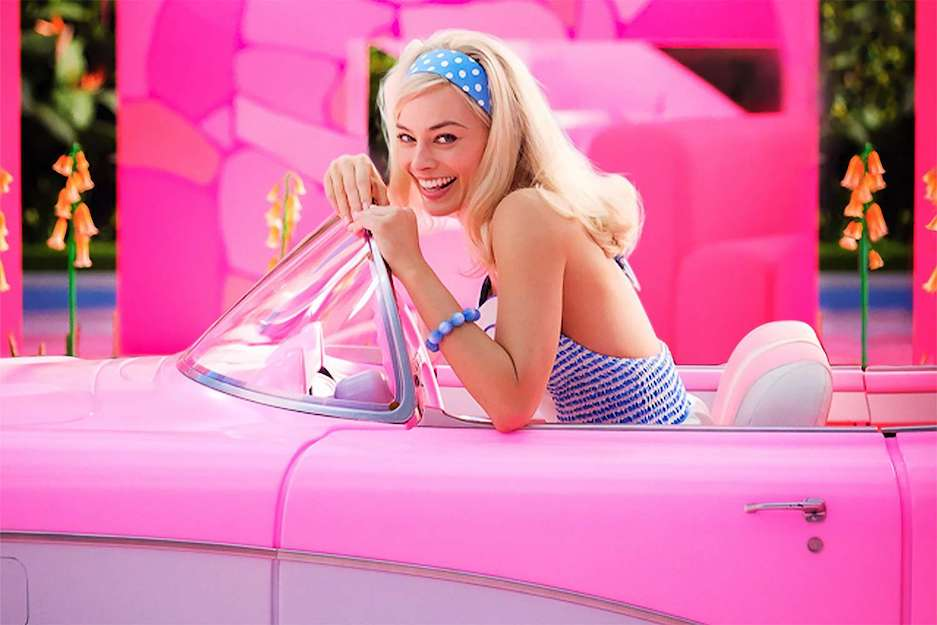

Our data is super duper pretty now!

## Analysis & Visualization Notebook

Now that we have our final dataset to work with, let's make some pretty graphs!

We are going to run analyses on Year, Runtime, Genre, IMDB Rating, Director, and Actor. We want to see the effect of these features on profitability as measured by the average gross profit, and the average ROI.

### Imports

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
plt.style.use(['ggplot', 'dark_background'])
sns.set_palette('viridis')
import warnings
warnings.simplefilter('ignore')

### Load in & prep the data

In [28]:
# Read in and display master data
df = pd.read_csv('./cleanedData/master_data.csv')

df.head(1)

,Unnamed: 0,Title,Budget,Domestic_Gross_Rev,Global_Gross_Rev,Year,Global_Gross_Profit,Global_Gross_ROI,Title & Year,ID,Runtime,Genres,AvgRating,VoteCount,Actors,Writers,Directors,Producers
0,0,Avatar,425000000.00,760507625.00,2776345279.00,2009,2351345279.00,5.53,Avatar - 2009,tt0499549,162,"Action,Adventure,Fantasy",7.90,1359426.00,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",NaN,James Cameron,Jon Landau


We can get this to look a little better before we start matplotlibbing. Let's drop a couple columns and make sure all data is ready for easy analysis.

In [29]:
# Delete these columns
del df['Unnamed: 0']
del df['Title & Year']
    
# Convert Runtime to integer after replacing some unknowns and nulls with zero
df['Runtime'] = df['Runtime'].replace('\\N', '0')
df['Runtime'] = df['Runtime'].fillna('0')
df['Runtime'] = df['Runtime'].astype(float).astype(int)

df.head(1)

,Title,Budget,Domestic_Gross_Rev,Global_Gross_Rev,Year,Global_Gross_Profit,Global_Gross_ROI,ID,Runtime,Genres,AvgRating,VoteCount,Actors,Writers,Directors,Producers
0,Avatar,425000000.00,760507625.00,2776345279.00,2009,2351345279.00,5.53,tt0499549,162,"Action,Adventure,Fantasy",7.90,1359426.00,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",NaN,James Cameron,Jon Landau


Looks great. Let's get a look at some of the most profitable movies to get the blood flowing.

### Most profitable films 

#### Formats for table displays

In [30]:
# Formatting float datatypes
formats = {'Budget': '${:,.0f}', 'Domestic_Gross_Rev': '${:,.0f}', 'Global_Gross_Rev': '${:,.0f}', 
           'Global_Gross_Profit': '${:,.0f}', 'Global_Gross_ROI': '{:.1f}x', 'AvgRating': '{:.2f}',
           'VoteCount': '{:.0f}'}

In [31]:
highest_profit_films = df[['Title', 'Global_Gross_Profit']].sort_values(
                         ['Global_Gross_Profit'], ascending=False).head(5)

highest_profit_films.style.format(formats).hide_index()

Title,Global_Gross_Profit
Avatar,"$2,351,345,279"
Avengers: Infinity War,"$1,748,134,200"
Jurassic World,"$1,433,854,864"
Furious 7,"$1,328,722,794"
The Avengers,"$1,292,935,897"


So for our dataset, these are the 5 most profitable by gross profit.

In [32]:
highest_ROI_films = df[['Title', 'Global_Gross_ROI']].sort_values(
                      ['Global_Gross_ROI'], ascending=False).head(5)
highest_ROI_films.style.format(formats).hide_index()

Title,Global_Gross_ROI
The Gallows,415.6x
Super Size Me,341.1x
Once,154.5x
Primer,119.3x
Napoleon Dynamite,114.3x


And these are the most profitable by return on investment, calculated as (gross profit / production cost).

### Profit by year

Let's see if we have have any trends over time.

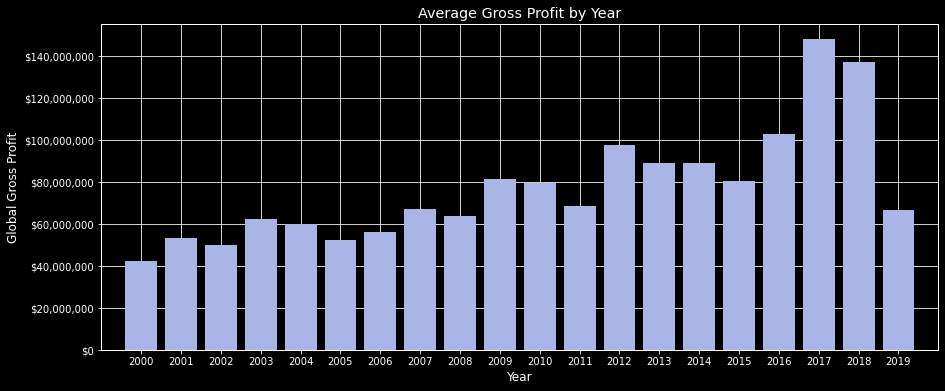

In [33]:
# Average Gross Profit by Year
profit_by_year = df[['Year', 'Global_Gross_Profit']].groupby('Year').mean()

fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(profit_by_year.index, profit_by_year['Global_Gross_Profit'], width=0.8, color='#a9b4e7')

ax.set_xlabel('Year')
ax.set_xticks(profit_by_year.index)
ax.set_xlim(1999, 2020)

ax.set_ylabel('Global Gross Profit')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

ax.set_title('Average Gross Profit by Year')

plt.savefig("./Images/gp_by_year.png", dpi=150)
plt.show();

So we do see pretty substantial growth. We suspect that the drop off in 2019 is due to having incomplete data at the time this dataset was compiled.

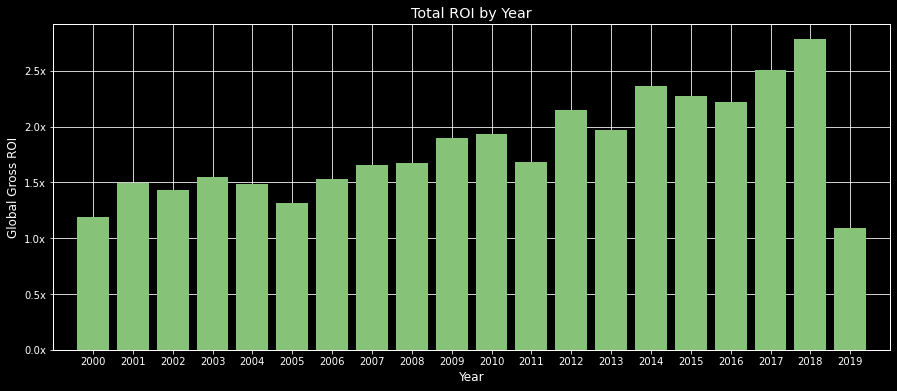

In [34]:
# Not using in presentation

# Total ROI by Year
ROI_by_year = df[['Year', 'Global_Gross_Profit', 'Budget']].groupby('Year').sum()
ROI_by_year['ROI'] = ROI_by_year['Global_Gross_Profit'] / ROI_by_year['Budget']

fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(ROI_by_year.index, ROI_by_year['ROI'], width=0.8, color='#86c277')

ax.set_xlabel('Year')
ax.set_xticks(ROI_by_year.index)
ax.set_xlim(1999, 2020)

ax.set_ylabel('Global Gross ROI')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}x'))

ax.set_title('Total ROI by Year')

plt.show();

We also note an upward trend here. Looks like studios have gotten more efficient with their money over time.

### Profit by runtime

We wonder if people are drawn more to a certain length of film?

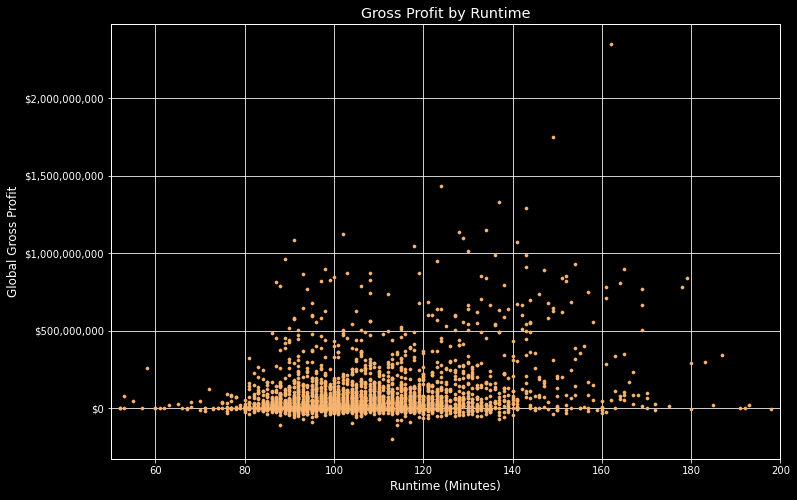

In [35]:
# Not using in presentation
# Profit by runtime
runtime_profit = df[['Runtime', 'Global_Gross_Profit']]

fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(runtime_profit['Runtime'], runtime_profit['Global_Gross_Profit'], s=10, color='#f7b370')

ax.set_xlabel('Runtime (Minutes)')
ax.set_xlim(50, 200)

ax.set_ylabel('Global Gross Profit')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

ax.set_title('Gross Profit by Runtime')

plt.show();

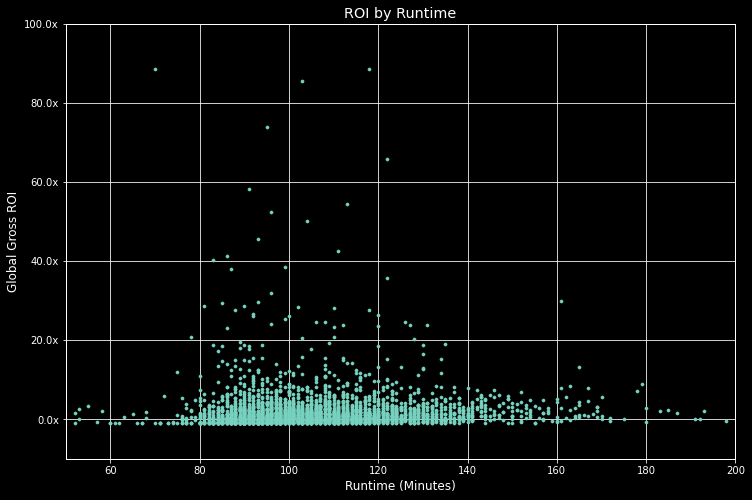

In [36]:
# Not using in presentation
# ROI by runtime
runtime_ROI = df[['Runtime', 'Global_Gross_ROI']]

fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(runtime_ROI['Runtime'], runtime_ROI['Global_Gross_ROI'], s=10, color='#77d1bf')

ax.set_xlabel('Runtime (Minutes)')
ax.set_xlim(50, 200)

ax.set_ylabel('Global Gross ROI')
ax.set_ylim(-10, 100)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}x'))

ax.set_title('ROI by Runtime')

plt.show();

There doesn't appear to be any significant pattern.

### Profit by genre

Now let's look at which genres generate the most money. We will have to get a little creative to parse out the individual genres.

In [37]:
# New df to work with
genres_exploded = df[['Title', 'Genres', 'Global_Gross_Profit', 'Global_Gross_ROI', 'Budget']]

# Fill null values to apply lambda function
genres_exploded['Genres'] = genres_exploded['Genres'].fillna("")

# Use .apply to parse the elements into a list
genres_exploded['Genres'] = genres_exploded['Genres'].apply(lambda x: x.split(","))

# Use .explode to pull out indvidual genres
genres_exploded = genres_exploded.explode('Genres')

# Remove null genres
genres_exploded = genres_exploded[genres_exploded['Genres'] != ""]

# Remove single instance of 'News' genre that leads to outlier in analysis
genres_exploded = genres_exploded[genres_exploded['Genres'] != "News"]

genres_exploded.head(10)

,Title,Genres,Global_Gross_Profit,Global_Gross_ROI,Budget
0,Avatar,Action,2351345279.00,5.53,425000000.00
0,Avatar,Adventure,2351345279.00,5.53,425000000.00
0,Avatar,Fantasy,2351345279.00,5.53,425000000.00
1,Pirates of the Caribbean: On Stranger Tides,Action,635063875.00,1.55,410600000.00
1,Pirates of the Caribbean: On Stranger Tides,Adventure,635063875.00,1.55,410600000.00
1,Pirates of the Caribbean: On Stranger Tides,Fantasy,635063875.00,1.55,410600000.00
2,Dark Phoenix,Action,-200237650.00,-0.57,350000000.00
2,Dark Phoenix,Adventure,-200237650.00,-0.57,350000000.00
2,Dark Phoenix,Sci-Fi,-200237650.00,-0.57,350000000.00
3,Avengers: Age of Ultron,Action,1072413963.00,3.24,330600000.00


Sweet! Now let's do some groupbys and graphs.

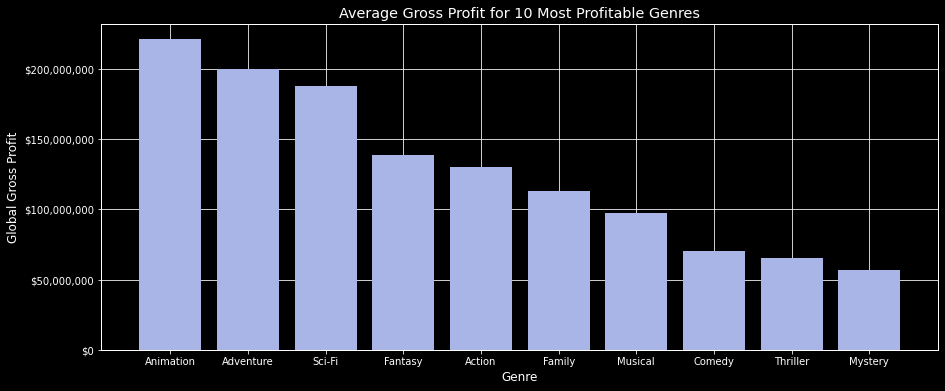

In [38]:
# Not using
# Average Gross Profit by Genre
profit_by_genre = genres_exploded.groupby('Genres').mean().sort_values(
                  'Global_Gross_Profit', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(profit_by_genre.index, profit_by_genre['Global_Gross_Profit'], width=0.8, color='#a9b4e7')

ax.set_xlabel('Genre')
ax.set_xticks(profit_by_genre.index)

ax.set_ylabel('Global Gross Profit')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

ax.set_title('Average Gross Profit for 10 Most Profitable Genres')

plt.show();

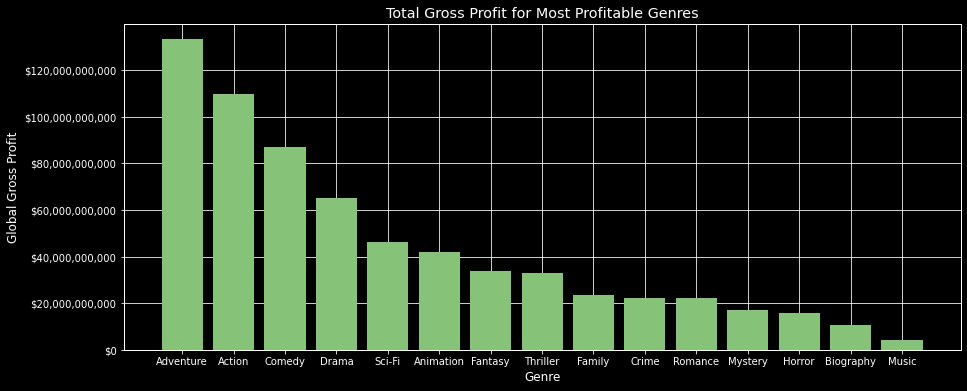

In [39]:
# Not using
# Total Gross Profit by Genre
profit_by_genre = genres_exploded.groupby('Genres').sum().sort_values(
                  'Global_Gross_Profit', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(profit_by_genre.index, profit_by_genre['Global_Gross_Profit'], width=0.8, color='#86c277')

ax.set_xlabel('Genre')
ax.set_xticks(profit_by_genre.index)

ax.set_ylabel('Global Gross Profit')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

ax.set_title('Total Gross Profit for Most Profitable Genres')

plt.show();

We like the look of this, but we want to see it next to total budget (which we do in tableau) to get a better picture of risk adjusted profit.

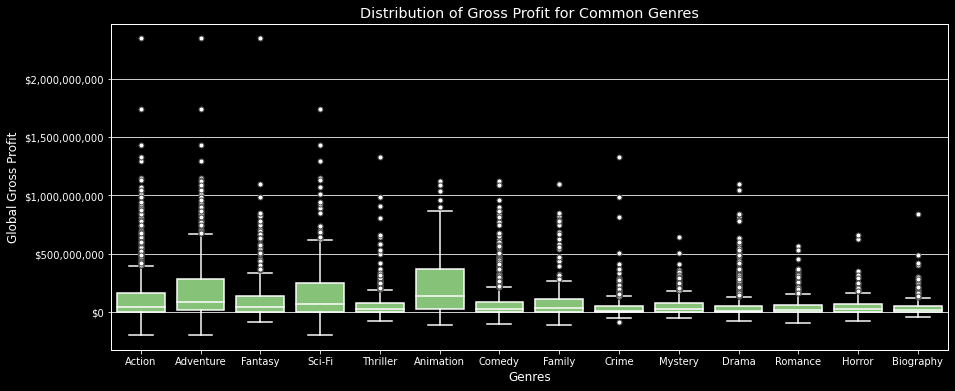

In [40]:
# Boxplot distribution of Gross Profits for common Genres
genres_types = genres_exploded['Genres'].value_counts()[lambda x : x > 150]
genres_df = genres_exploded[genres_exploded['Genres'].isin(genres_types.index)]

fig, ax = plt.subplots(figsize=(15,6))

PROPS = {
    'boxprops':{'facecolor':'#86c277', 'edgecolor':'white'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'},
    'flierprops':{'marker': 'o',
                 'markerfacecolor': 'white'}
}

sns.boxplot(x = 'Genres', y='Global_Gross_Profit', data = genres_df, **PROPS)

ax.set_title('Distribution of Gross Profit for Common Genres')

ax.set_ylabel('Global Gross Profit')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

plt.savefig("./Images/dist_gp_genre.png", dpi=150);

This is awesome. We see that action adventure movies may have the largest amount of profit, but they are also quite risky. Lot's more volatility in their distributions than, say horror films.

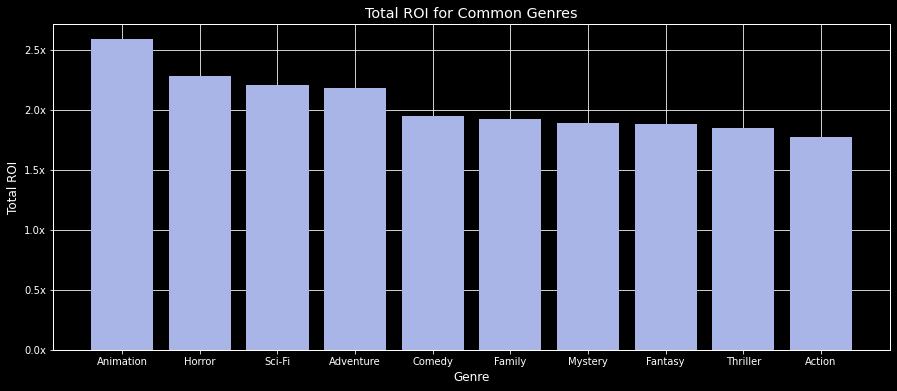

In [41]:
# Total ROI for common Genres
genres_types = genres_exploded['Genres'].value_counts()[lambda x : x > 150]
genres_df = genres_exploded[genres_exploded['Genres'].isin(genres_types.index)]

ROI_by_genre = genres_df.groupby('Genres').sum()
ROI_by_genre['ROI'] = ROI_by_genre['Global_Gross_Profit'] / ROI_by_genre['Budget']
ROI_by_genre = ROI_by_genre.sort_values('ROI', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(ROI_by_genre.index, ROI_by_genre['ROI'], width=0.8, color='#a9b4e7')

ax.set_xlabel('Genre')
ax.set_xticks(ROI_by_genre.index)

ax.set_ylabel('Total ROI')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}x'))

ax.set_title('Total ROI for Common Genres')

plt.savefig("./Images/dist_gp_genre.png", dpi=150)
plt.show();

ROI cuts through the noise a bit more. We can see that by this metric, Animation and Horror movies are quite profitable.

### Profit by director

We'll do the same process we did for genres here.

In [42]:
# New df to work with
directors_exploded = df[['Title', 'Directors', 'Global_Gross_Profit', 'Global_Gross_ROI', 'Budget']]

# Fill null values to apply lambda function
directors_exploded['Directors'] = directors_exploded['Directors'].fillna("")

# Use .apply to parse the elements into a list
directors_exploded['Directors'] = directors_exploded['Directors'].apply(lambda x: x.split(","))

# Use .explode to pull out indvidual directors
directors_exploded = directors_exploded.explode('Directors')

# Remove null directors
directors_exploded = directors_exploded[directors_exploded['Directors'] != ""]

directors_exploded.head(10)

,Title,Directors,Global_Gross_Profit,Global_Gross_ROI,Budget
0,Avatar,James Cameron,2351345279.00,5.53,425000000.00
1,Pirates of the Caribbean: On Stranger Tides,Rob Marshall,635063875.00,1.55,410600000.00
2,Dark Phoenix,Simon Kinberg,-200237650.00,-0.57,350000000.00
3,Avengers: Age of Ultron,Joss Whedon,1072413963.00,3.24,330600000.00
4,Avengers: Infinity War,Anthony Russo,1748134200.00,5.83,300000000.00
4,Avengers: Infinity War,Joe Russo,1748134200.00,5.83,300000000.00
5,Pirates of the Caribbean: At World's End,Gore Verbinski,663420425.00,2.21,300000000.00
6,Justice League,Zack Snyder,355945209.00,1.19,300000000.00
7,Spectre,Sam Mendes,579620923.00,1.93,300000000.00
8,The Dark Knight Rises,Christopher Nolan,809439099.00,2.94,275000000.00


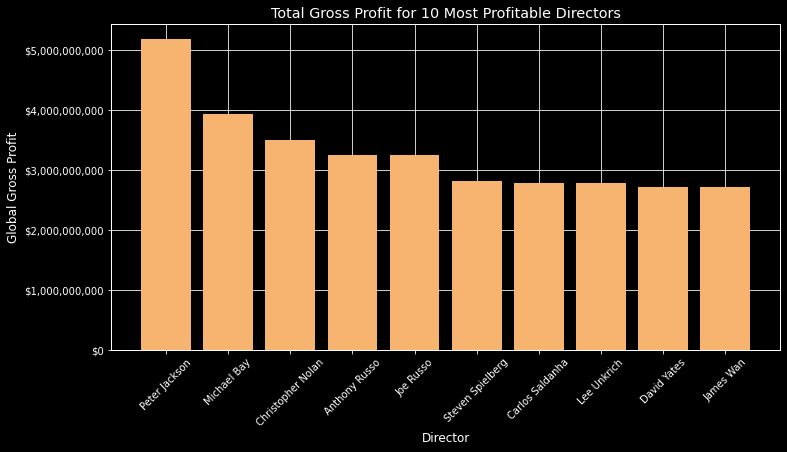

In [43]:
# Not using
# Total Gross Profit by Director
profit_by_director = directors_exploded.groupby('Directors').sum().sort_values(
                  'Global_Gross_Profit', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(profit_by_director.index, profit_by_director['Global_Gross_Profit'], width=0.8, color='#f7b370')

ax.set_xlabel('Director')
ax.set_xticks(profit_by_director.index)
plt.xticks(rotation=45)

ax.set_ylabel('Global Gross Profit')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

ax.set_title('Total Gross Profit for 10 Most Profitable Directors')

plt.show();

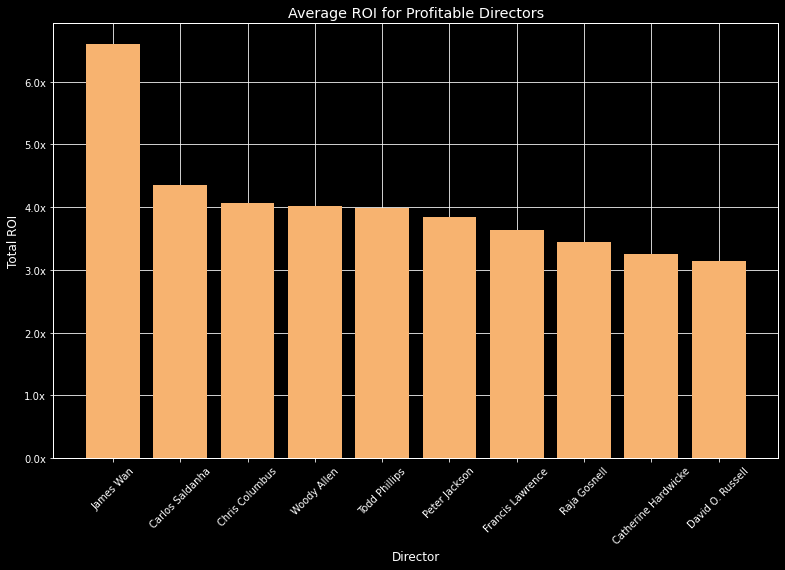

In [44]:
# Average ROI by Director for directors with more than 5 films
common_directors = directors_exploded['Directors'].value_counts()[lambda x : x > 5]
directors_df = directors_exploded[directors_exploded['Directors'].isin(common_directors.index)]

ROI_by_director = directors_df.groupby('Directors').sum()
ROI_by_director['ROI'] = ROI_by_director['Global_Gross_Profit'] / ROI_by_director['Budget']
ROI_by_director = ROI_by_director.sort_values('ROI', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(13, 8))

ax.bar(ROI_by_director.index, ROI_by_director['ROI'], width=0.8, color='#f7b370')

ax.set_xlabel('Director')
ax.set_xticks(ROI_by_director.index)
plt.xticks(rotation=45)

ax.set_ylabel('Total ROI')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}x'))

ax.set_title('Average ROI for Profitable Directors')

plt.savefig("./Images/roi_directors.png", dpi=150)
plt.show();

### Profit by actor

We'll do the same process we did for genres here.

In [45]:
# New df to work with
actors_exploded = df[['Title', 'Actors', 'Global_Gross_Profit', 'Global_Gross_ROI', 'Budget']]

# Fill null values to apply lambda function
actors_exploded['Actors'] = actors_exploded['Actors'].fillna("")

# Use .apply to parse the elements into a list
actors_exploded['Actors'] = actors_exploded['Actors'].apply(lambda x: x.split(","))

# Use .explode to pull out indvidual actors
actors_exploded = actors_exploded.explode('Actors')

# Remove null actors
actors_exploded = actors_exploded[actors_exploded['Actors'] != ""]

actors_exploded.head(10)

,Title,Actors,Global_Gross_Profit,Global_Gross_ROI,Budget
0,Avatar,Sam Worthington,2351345279.00,5.53,425000000.00
0,Avatar,Zoe Saldana,2351345279.00,5.53,425000000.00
0,Avatar,Sigourney Weaver,2351345279.00,5.53,425000000.00
0,Avatar,Michelle Rodriguez,2351345279.00,5.53,425000000.00
1,Pirates of the Caribbean: On Stranger Tides,Johnny Depp,635063875.00,1.55,410600000.00
1,Pirates of the Caribbean: On Stranger Tides,Penélope Cruz,635063875.00,1.55,410600000.00
1,Pirates of the Caribbean: On Stranger Tides,Ian McShane,635063875.00,1.55,410600000.00
1,Pirates of the Caribbean: On Stranger Tides,Geoffrey Rush,635063875.00,1.55,410600000.00
2,Dark Phoenix,James McAvoy,-200237650.00,-0.57,350000000.00
2,Dark Phoenix,Michael Fassbender,-200237650.00,-0.57,350000000.00


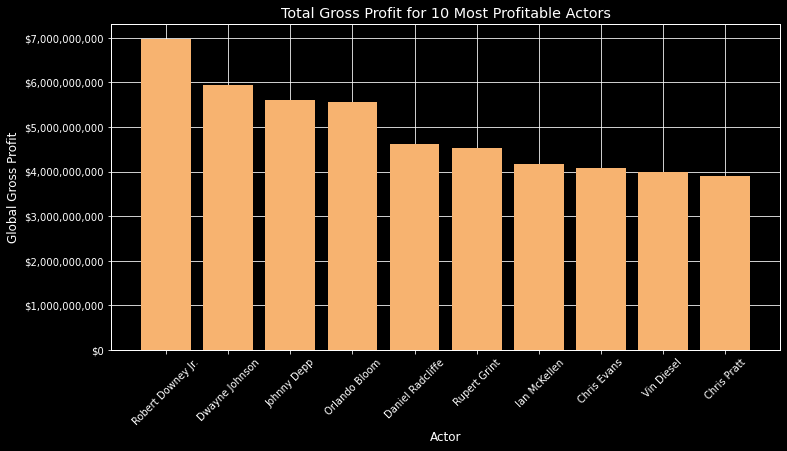

In [46]:
# Not using
# Total Gross Profit by Actor
profit_by_actor = actors_exploded.groupby('Actors').sum().sort_values(
                  'Global_Gross_Profit', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(profit_by_actor.index, profit_by_actor['Global_Gross_Profit'], width=0.8, color='#f7b370')

ax.set_xlabel('Actor')
ax.set_xticks(profit_by_actor.index)
plt.xticks(rotation=45)

ax.set_ylabel('Global Gross Profit')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

ax.set_title('Total Gross Profit for 10 Most Profitable Actors')

plt.show();

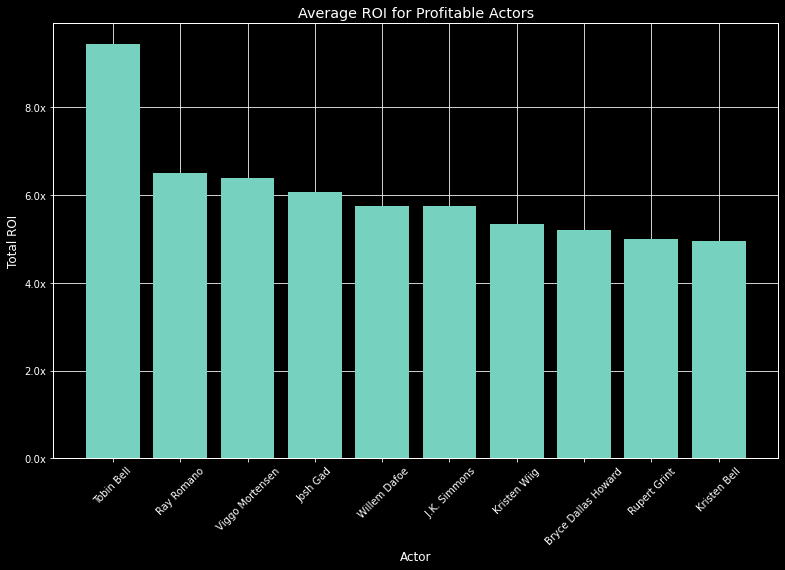

In [47]:
# Average ROI by Actor for actors in at least 5 films
common_actors = actors_exploded['Actors'].value_counts()[lambda x : x >= 5]
actors_df = actors_exploded[actors_exploded['Actors'].isin(common_actors.index)]

ROI_by_actor = actors_df.groupby('Actors').sum()
ROI_by_actor['ROI'] = ROI_by_actor['Global_Gross_Profit'] / ROI_by_actor['Budget']
ROI_by_actor = ROI_by_actor.sort_values('ROI', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(13, 8))

ax.bar(ROI_by_actor.index, ROI_by_actor['ROI'], width=0.8, color='#77d1bf')

ax.set_xlabel('Actor')
ax.set_xticks(ROI_by_actor.index)
plt.xticks(rotation=45)

ax.set_ylabel('Total ROI')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}x'))

ax.set_title('Average ROI for Profitable Actors')

plt.savefig("./Images/roi_actors.png", dpi=150)
plt.show();

See the ReadMe or the presentation for the simpler story on why Horror movies are the way to go.

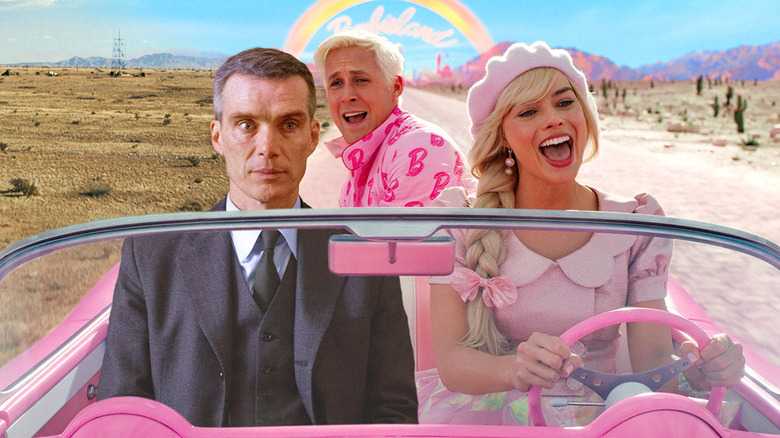